<a href="https://colab.research.google.com/github/martinjpage/DSI/blob/master/Martin_Page_Module_2_Twist_Challenge_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook can be used to analyse video files of a convery system carrying materals, and predict the material composition by sampling the frames of the video and passing those samples to a trained model.

## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Libraries

In [2]:
from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from fastai.vision import *
import random
from collections import Counter
import pandas as pd

## Define Functions

### Image Sampling Function

In [3]:
def sample_fastai(img_orig, x, y, win_size, cnn_size):

  ''' This function takes an image as input, converts it for use
  with the fastai library, and then takes a sub-sample of the image '''

  img = Image(pil2tensor(img_orig, dtype=np.float32).div_(255)) 
  h, w, = img.shape[1], img.shape[2]

  delta = int(win_size/2)

  x0 = x - delta 
  x1 = x + delta
  y0 = y - delta
  y1 = y + delta

  if y0 < 0:
      y0 = int(0)
      y1 = int(win_size * 2)
  
  if y1 > h:
      y0 = int(h - win_size * 2)
      y1 = int(h)
  
  if x0 < 0:
      x0 = int(0)
      x1 = int(win_size * 2)
  
  if x1 > w:
      x0 = int(w - win_size * 2)
      x1 = int(w)

  img_sample = img.crop((x0,y0,x1,y1))

  img_cnn = img_sample.resize(cnn_size)

  return img_cnn, [x0,x1,y0,y1]

### Video prediction function

Define functions that take a video path as an input and optionally the number of image sub-samples per frame, makes a prediction on each sub-sample and adds the proportion of classes identified in each frame to a row of a dataframe. It also evaluates changes in the proportion of classes. A 30% change in any class between frames causes a notification to be printed and that frame saved. Returns a dataframe of class proportions per frame, a list of frame numbers where changes took place and a timers of the average analysis time per frame.

Currently, each video has its own function because of custom cropping - each video is trimmed to work with only the central clean area that contains the material of interest and avoid peripheral anomalies such as the date-time stamp, the edge of the conveyor belt, etc.

In [85]:
def video_prediction1(vid_path, num_samples = 7, sample_window_size = 100, cnn_img_size = 224):
  
  ''' Function takes a video path as an input and optionally the number of image sub-samples
  per frame, makes a prediction on each sub-sample and adds the proportion of classes identified
  in each frame to a row of a dataframe. It also evaluates changes in the proportion of classes.
  A 30% change in any class between frames causes a notification to be printed and that frame saved.
  
  Returns a dataframe of class proportions per frame, a list of frame numbers where changes took place and
  a timers of the average analysis time per frame '''

  # create iterable object of the video define by the video path
  cap = cv2.VideoCapture(vid_path)

  # get the number of frames in the video
  N_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  ## for loop to iterate over all the frames from the video

  # create a df to save the proportion of each classes in each frame, calculated on the sampling
  df_prop = pd.DataFrame(columns = ["fines", "lump", "chip", "mixed", "pellets"])

  #create list to save frames that have a change from the previous frame
  change_points = []

  print("Starting video loop for", N_frames, "frames")
  ## start timer to record how long the loop takes to run
  tic = time.process_time()
  for frame_num in range(N_frames):
  #for frame_num in range(5):
    #print("assessing frame:", frame_num)
    has_img, img = cap.read() # Blue, Green, Red Numpy Array uint8

    if has_img:
      
      #crop image to get only the clean centre
      crop_img = img[30:430, 145:420]

      # take num_samples number of random samples of different regions of frame, defined by the offset, 
      # which is shuffled around to give random x and y coordinates
      
      x_offsets = np.linspace(-50, 50, num_samples)
      x_offsets = np.random.permutation(x_offsets)

      y_offsets = np.linspace(-50, 50, num_samples)
      y_offsets = np.random.permutation(y_offsets)

      ## for loop to iterate overall the samples in current frame
      
      #create a list to save the predictions of the samples
      sample_preds = []

      for i in range(num_samples):
      
        # Grab an image sample of the cropped frame. X=0, Y=0 is the top left corner. X and Y indicates the approx. center of the sample.
        x = 200 + x_offsets[i]
        y = 137 + y_offsets[i]
        sample, rect = sample_fastai(crop_img, int(x), int(y), sample_window_size, cnn_img_size)
      
        #make prediction on sample image using fastai model
        pred_class, pred_idx, outputs = learn.predict(sample)
        
        #save the predictions of the sample to sample_pred list
        sample_preds.append(pred_class.obj)

      # count the number of predictions for each class across the sub-samples
      pred_count = Counter(sample_preds)

      #add any missing classes to equal 0 to the pred_counts dictionary
      keys = ["fines", "lump", "chip", "mixed", "pellets"]
      for key in keys:
        if key not in list(pred_count.keys()):
          pred_count[key] = 0

      # convert the dictionary to a dataframe with columns = the classes and rows = the frame number
      df_temp_count = pd.DataFrame.from_dict(pred_count, orient='index').transpose()

      #convert the counts to a proportion
      df_temp_prop = df_temp_count.divide(df_temp_count.sum(axis=1), axis=0)

      #add the temporary proportion df to the prop df as a row and reset the row index
      df_prop = pd.concat([df_prop, df_temp_prop], axis = 0)
      df_prop.reset_index(drop=True, inplace=True)
      
      #check if there has been 30%+ change in any class compared to the previous frame and if so, print a 
      #notiftication message of the classes that have changes and indicate that the image of the frame should be saved
      
      save_image = False
      # do this for all frames except frame 0
      if frame_num > 0:
        # iterate over the 5 classes (columns in the data frame)
        for i in range(5):
          #compare the latest row in the dataframe to the previous row in the dataframe along each column, looking for a 30% change
          #in the sample proportions o f any column
          if  not (df_prop.iloc[frame_num-1,:][i] * 1.3 >= df_prop.iloc[frame_num,:][i] >= df_prop.iloc[frame_num-1,:][i] * 0.7):
            #print a message if change is detected
            print("change found in frame:", frame_num, "; class:", df_prop.columns[i])
            #save the frame number
            change_points.append(frame_num)
            #indicate that the image of the frame must be saved
            save_image = True

      # save the image of the first frame as well as any frame where a change was identified
      if frame_num == 0 or save_image:
        plt.imsave('/content/drive/My Drive/Video frame outputs/bin1/' + vid_path[-9:-4] + "_" + str(frame_num) + ".png", img)    

  #remove duplicates in the change points list and sort the list in numerical order
  change_points = list(set(change_points)) 
  change_points.sort()

  #calculate averge procesing time per frame
  dt = time.process_time() - tic
  timer = dt/N_frames # Samples per frame should be below 150 ms

  print("End of process")
  return df_prop, change_points, timer

In [64]:
def video_prediction2(vid_path, num_samples = 7, sample_window_size = 100, cnn_img_size = 224):
  ''' Function takes a video path as an input and optionally the number of image sub-samples
  per frame, makes a prediction on each sub-sample and adds the proportion of classes identified
  in each frame to a row of a dataframe. It also evaluates changes in the proportion of classes.
  A 30% change in any class between frames causes a notification to be printed and that frame saved.
  
  Returns a dataframe of class proportions per frame, a list of frame numbers where changes took place and
  a timers of the average analysis time per frame '''
  
  # create iterable object of the video define by the video path
  cap = cv2.VideoCapture(vid_path)

  # get the number of frames in the video
  N_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  ## for loop to iterate over all the frames from the video

  # create a df to save the number of each classes in each frame
  df_prop = pd.DataFrame(columns = ["fines", "lump", "chip", "mixed", "pellets"])

  #create list to save frames that have a change from the previous frame
  change_points = []

  print("Starting video loop for", N_frames, "frames")
  ## start timer to record how long the loop takes to run
  tic = time.process_time()
  for frame_num in range(N_frames):
  #for frame_num in range(5):
    #print("assessing frame:", frame_num)
    has_img, img = cap.read() # Blue, Green, Red Numpy Array uint8

    if has_img:
      
      #crop image to get only the clean centre
      crop_img = img[50:430, 40:450]

      # take num_samples number of random samples of different regions of frame, defined by the offset, 
      # which is shuffled around to give random x and y coordinates
      
      x_offsets = np.linspace(-50, 50, num_samples)
      x_offsets = np.random.permutation(x_offsets)

      y_offsets = np.linspace(-50, 50, num_samples)
      y_offsets = np.random.permutation(y_offsets)

      ## for loop to iterate overall the samples in current frame
      
      #create a list to save the predictions of the samples
      sample_preds = []

      for i in range(num_samples):
      
        # Grab an image sample of the cropped frame. X=0, Y=0 is the top left corner. X and Y indicates the approx. center of the sample.
        x = 205 + x_offsets[i]
        y = 190 + y_offsets[i]
        sample, rect = sample_fastai(crop_img, int(x), int(y), sample_window_size, cnn_img_size)
      
        #make prediction on sample image using fastai model
        pred_class, pred_idx, outputs = learn.predict(sample)
        
        #save the predictions of the sample to sample_pred list
        sample_preds.append(pred_class.obj)

      # count the number of predictions for each class across the sub-samples
      pred_count = Counter(sample_preds)

      #add any missing classes to equal 0 to the pred_counts dictionary
      keys = ["fines", "lump", "chip", "mixed", "pellets"]
      for key in keys:
        if key not in list(pred_count.keys()):
          pred_count[key] = 0

      # convert the dictionary to a dataframe with columns = the classes and rows = the frame number
      df_temp_count = pd.DataFrame.from_dict(pred_count, orient='index').transpose()

      #convert the counts to a proportion
      df_temp_prop = df_temp_count.divide(df_temp_count.sum(axis=1), axis=0)

      #add the temporary proportion df to the prop df as a row and reset the row index
      df_prop = pd.concat([df_prop, df_temp_prop], axis = 0)
      df_prop.reset_index(drop=True, inplace=True)
      
      #check if there has been 30%+ change in any class compared to the previous frame and if so, print a 
      #notiftication message of the classes that have changes and indicate that the image of the frame should be saved
      
      save_image = False
      # do this for all frames except frame 0
      if frame_num > 0:
        # iterate over the 5 classes (columns in the data frame)
        for i in range(5):
          #compare the latest row in the dataframe to the previous row in the dataframe along each column, looking for a 30% change
          #in the sample proportions o f any column
          if  not (df_prop.iloc[frame_num-1,:][i] * 1.3 >= df_prop.iloc[frame_num,:][i] >= df_prop.iloc[frame_num-1,:][i] * 0.7):
            #print a message if change is detected
            print("change found in frame:", frame_num, "; class:", df_prop.columns[i])
            #save the frame number
            change_points.append(frame_num)
            #indicate that the image of the frame must be saved
            save_image = True

      # save the image of the first frame as well as any frame where a change was identified
      if frame_num == 0 or save_image:
        plt.imsave('/content/drive/My Drive/Video frame outputs/bin2/' + vid_path[-9:-4] + "_" + str(frame_num) + ".png", img)    

  #remove duplicates in the change points list and sort the list in numerical order
  change_points = list(set(change_points)) 
  change_points.sort()

  #calculate averge procesing time per frame
  dt = time.process_time() - tic
  timer = dt/N_frames # Samples per frame should be below 150 ms

  print("End of process")
  return df_prop, change_points, timer

In [88]:
def video_prediction3(vid_path, num_samples = 7, sample_window_size = 100, cnn_img_size = 224):
  ''' Function takes a video path as an input and optionally the number of image sub-samples
  per frame, makes a prediction on each sub-sample and adds the proportion of classes identified
  in each frame to a row of a dataframe. It also evaluates changes in the proportion of classes.
  A 30% change in any class between frames causes a notification to be printed and that frame saved.
  
  Returns a dataframe of class proportions per frame, a list of frame numbers where changes took place and
  a timers of the average analysis time per frame '''
  
  # create iterable object of the video define by the video path
  cap = cv2.VideoCapture(vid_path)

  # get the number of frames in the video
  N_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  ## for loop to iterate over all the frames from the video

  # create a df to save the number of each classes in each frame
  df_prop = pd.DataFrame(columns = ["fines", "lump", "chip", "mixed", "pellets"])

  #create list to save frames that have a change from the previous frame
  change_points = []

  print("Starting video loop for", N_frames, "frames")
  ## start timer to record how long the loop takes to run
  tic = time.process_time()
  for frame_num in range(N_frames):
  #for frame_num in range(5):
    #print("assessing frame:", frame_num)
    has_img, img = cap.read() # Blue, Green, Red Numpy Array uint8

    if has_img:
      
      #crop image to get only the clean centre
      crop_img = img[50:450, 20:400]

      # take num_samples number of random samples of different regions of frame, defined by the offset, 
      # which is shuffled around to give random x and y coordinates
      
      x_offsets = np.linspace(-50, 50, num_samples)
      x_offsets = np.random.permutation(x_offsets)

      y_offsets = np.linspace(-50, 50, num_samples)
      y_offsets = np.random.permutation(y_offsets)

      ## for loop to iterate overall the samples in current frame
      
      #create a list to save the predictions of the samples
      sample_preds = []

      for i in range(num_samples):
      
        # Grab an image sample of the cropped frame. X=0, Y=0 is the top left corner. X and Y indicates the approx. center of the sample.
        x = 190 + x_offsets[i]
        y = 200 + y_offsets[i]
        sample, rect = sample_fastai(crop_img, int(x), int(y), sample_window_size, cnn_img_size)
      
        #make prediction on sample image using fastai model
        pred_class, pred_idx, outputs = learn.predict(sample)
        
        #save the predictions of the sample to sample_pred list
        sample_preds.append(pred_class.obj)

      # count the number of predictions for each class across the sub-samples
      pred_count = Counter(sample_preds)

      #add any missing classes to equal 0 to the pred_counts dictionary
      keys = ["fines", "lump", "chip", "mixed", "pellets"]
      for key in keys:
        if key not in list(pred_count.keys()):
          pred_count[key] = 0

      # convert the dictionary to a dataframe with columns = the classes and rows = the frame number
      df_temp_count = pd.DataFrame.from_dict(pred_count, orient='index').transpose()

      #convert the counts to a proportion
      df_temp_prop = df_temp_count.divide(df_temp_count.sum(axis=1), axis=0)

      #add the temporary proportion df to the prop df as a row and reset the row index
      df_prop = pd.concat([df_prop, df_temp_prop], axis = 0)
      df_prop.reset_index(drop=True, inplace=True)
      
      #check if there has been 30%+ change in any class compared to the previous frame and if so, print a 
      #notiftication message of the classes that have changes and indicate that the image of the frame should be saved
      
      save_image = False
      # do this for all frames except frame 0
      if frame_num > 0:
        # iterate over the 5 classes (columns in the data frame)
        for i in range(5):
          #compare the latest row in the dataframe to the previous row in the dataframe along each column, looking for a 30% change
          #in the sample proportions o f any column
          if  not (df_prop.iloc[frame_num-1,:][i] * 1.3 >= df_prop.iloc[frame_num,:][i] >= df_prop.iloc[frame_num-1,:][i] * 0.7):
            #print a message if change is detected
            print("change found in frame:", frame_num, "; class:", df_prop.columns[i])
            #save the frame number
            change_points.append(frame_num)
            #indicate that the image of the frame must be saved
            save_image = True

      # save the image of the first frame as well as any frame where a change was identified
      if frame_num == 0 or save_image:
        plt.imsave('/content/drive/My Drive/Video frame outputs/bin3/' + vid_path[-9:-4] + "_" + str(frame_num) + ".png", img)    

  #remove duplicates in the change points list and sort the list in numerical order
  change_points = list(set(change_points)) 
  change_points.sort()

  #calculate averge procesing time per frame
  dt = time.process_time() - tic
  timer = dt/N_frames # Samples per frame should be below 150 ms

  print("End of process")
  return df_prop, change_points, timer

In [87]:
def video_prediction4(vid_path, num_samples = 7, sample_window_size = 100, cnn_img_size = 224):
  ''' Function takes a video path as an input and optionally the number of image sub-samples
  per frame, makes a prediction on each sub-sample and adds the proportion of classes identified
  in each frame to a row of a dataframe. It also evaluates changes in the proportion of classes.
  A 30% change in any class between frames causes a notification to be printed and that frame saved.
  
  Returns a dataframe of class proportions per frame, a list of frame numbers where changes took place and
  a timers of the average analysis time per frame '''
  
  # create iterable object of the video define by the video path
  cap = cv2.VideoCapture(vid_path)

  # get the number of frames in the video
  N_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  ## for loop to iterate over all the frames from the video

  # create a df to save the number of each classes in each frame
  df_prop = pd.DataFrame(columns = ["fines", "lump", "chip", "mixed", "pellets"])

  #create list to save frames that have a change from the previous frame
  change_points = []

  print("Starting video loop for", N_frames, "frames")
  ## start timer to record how long the loop takes to run
  tic = time.process_time()
  for frame_num in range(N_frames):
  #for frame_num in range(5):
    #print("assessing frame:", frame_num)
    has_img, img = cap.read() # Blue, Green, Red Numpy Array uint8

    if has_img:
      
      #crop image to get only the clean centre
      crop_img = img[60:410, 65:410]

      # take num_samples number of random samples of different regions of frame, defined by the offset, 
      # which is shuffled around to give random x and y coordinates
      
      x_offsets = np.linspace(-50, 50, num_samples)
      x_offsets = np.random.permutation(x_offsets)

      y_offsets = np.linspace(-50, 50, num_samples)
      y_offsets = np.random.permutation(y_offsets)

      ## for loop to iterate overall the samples in current frame
      
      #create a list to save the predictions of the samples
      sample_preds = []

      for i in range(num_samples):
      
        # Grab an image sample of the cropped frame. X=0, Y=0 is the top left corner. X and Y indicates the approx. center of the sample.
        x = 170 + x_offsets[i]
        y = 170 + y_offsets[i]
        sample, rect = sample_fastai(crop_img, int(x), int(y), sample_window_size, cnn_img_size)
      
        #make prediction on sample image using fastai model
        pred_class, pred_idx, outputs = learn.predict(sample)
        
        #save the predictions of the sample to sample_pred list
        sample_preds.append(pred_class.obj)

      # count the number of predictions for each class across the sub-samples
      pred_count = Counter(sample_preds)

      #add any missing classes to equal 0 to the pred_counts dictionary
      keys = ["fines", "lump", "chip", "mixed", "pellets"]
      for key in keys:
        if key not in list(pred_count.keys()):
          pred_count[key] = 0

      # convert the dictionary to a dataframe with columns = the classes and rows = the frame number
      df_temp_count = pd.DataFrame.from_dict(pred_count, orient='index').transpose()

      #convert the counts to a proportion
      df_temp_prop = df_temp_count.divide(df_temp_count.sum(axis=1), axis=0)

      #add the temporary proportion df to the prop df as a row and reset the row index
      df_prop = pd.concat([df_prop, df_temp_prop], axis = 0)
      df_prop.reset_index(drop=True, inplace=True)
      
      #check if there has been 30%+ change in any class compared to the previous frame and if so, print a 
      #notiftication message of the classes that have changes and indicate that the image of the frame should be saved
      
      save_image = False
      # do this for all frames except frame 0
      if frame_num > 0:
        # iterate over the 5 classes (columns in the data frame)
        for i in range(5):
          #compare the latest row in the dataframe to the previous row in the dataframe along each column, looking for a 30% change
          #in the sample proportions o f any column
          if  not (df_prop.iloc[frame_num-1,:][i] * 1.3 >= df_prop.iloc[frame_num,:][i] >= df_prop.iloc[frame_num-1,:][i] * 0.7):
            #print a message if change is detected
            print("change found in frame:", frame_num, "; class:", df_prop.columns[i])
            #save the frame number
            change_points.append(frame_num)
            #indicate that the image of the frame must be saved
            save_image = True

      # save the image of the first frame as well as any frame where a change was identified
      if frame_num == 0 or save_image:
        plt.imsave('/content/drive/My Drive/Video frame outputs/bin4/' + vid_path[-9:-4] + "_" + str(frame_num) + ".png", img)    

  #remove duplicates in the change points list and sort the list in numerical order
  change_points = list(set(change_points)) 
  change_points.sort()

  #calculate averge procesing time per frame
  dt = time.process_time() - tic
  timer = dt/N_frames # Samples per frame should be below 150 ms

  print("End of process")
  return df_prop, change_points, timer

In [67]:
def video_prediction5(vid_path, num_samples = 7, sample_window_size = 100, cnn_img_size = 224):
  ''' Function takes a video path as an input and optionally the number of image sub-samples
  per frame, makes a prediction on each sub-sample and adds the proportion of classes identified
  in each frame to a row of a dataframe. It also evaluates changes in the proportion of classes.
  A 30% change in any class between frames causes a notification to be printed and that frame saved.
  
  Returns a dataframe of class proportions per frame, a list of frame numbers where changes took place and
  a timers of the average analysis time per frame '''
  
  # create iterable object of the video define by the video path
  cap = cv2.VideoCapture(vid_path)

  # get the number of frames in the video
  N_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  ## for loop to iterate over all the frames from the video

  # create a df to save the number of each classes in each frame
  df_prop = pd.DataFrame(columns = ["fines", "lump", "chip", "mixed", "pellets"])

  #create list to save frames that have a change from the previous frame
  change_points = []

  print("Starting video loop for", N_frames, "frames")
  ## start timer to record how long the loop takes to run
  tic = time.process_time()
  for frame_num in range(N_frames):
  #for frame_num in range(5):
    #print("assessing frame:", frame_num)
    has_img, img = cap.read() # Blue, Green, Red Numpy Array uint8

    if has_img:
      
      #crop image to get only the clean centre
      crop_img = img[40:410, 40:420]

      # take num_samples number of random samples of different regions of frame, defined by the offset, 
      # which is shuffled around to give random x and y coordinates
      
      x_offsets = np.linspace(-50, 50, num_samples)
      x_offsets = np.random.permutation(x_offsets)

      y_offsets = np.linspace(-50, 50, num_samples)
      y_offsets = np.random.permutation(y_offsets)

      ## for loop to iterate overall the samples in current frame
      
      #create a list to save the predictions of the samples
      sample_preds = []

      for i in range(num_samples):
      
        # Grab an image sample of the cropped frame. X=0, Y=0 is the top left corner. X and Y indicates the approx. center of the sample.
        x = 185 + x_offsets[i]
        y = 185 + y_offsets[i]
        sample, rect = sample_fastai(crop_img, int(x), int(y), sample_window_size, cnn_img_size)
      
        #make prediction on sample image using fastai model
        pred_class, pred_idx, outputs = learn.predict(sample)
        
        #save the predictions of the sample to sample_pred list
        sample_preds.append(pred_class.obj)

      # count the number of predictions for each class across the sub-samples
      pred_count = Counter(sample_preds)

      #add any missing classes to equal 0 to the pred_counts dictionary
      keys = ["fines", "lump", "chip", "mixed", "pellets"]
      for key in keys:
        if key not in list(pred_count.keys()):
          pred_count[key] = 0

      # convert the dictionary to a dataframe with columns = the classes and rows = the frame number
      df_temp_count = pd.DataFrame.from_dict(pred_count, orient='index').transpose()

      #convert the counts to a proportion
      df_temp_prop = df_temp_count.divide(df_temp_count.sum(axis=1), axis=0)

      #add the temporary proportion df to the prop df as a row and reset the row index
      df_prop = pd.concat([df_prop, df_temp_prop], axis = 0)
      df_prop.reset_index(drop=True, inplace=True)
      
      #check if there has been 30%+ change in any class compared to the previous frame and if so, print a 
      #notiftication message of the classes that have changes and indicate that the image of the frame should be saved
      
      save_image = False
      # do this for all frames except frame 0
      if frame_num > 0:
        # iterate over the 5 classes (columns in the data frame)
        for i in range(5):
          #compare the latest row in the dataframe to the previous row in the dataframe along each column, looking for a 30% change
          #in the sample proportions o f any column
          if  not (df_prop.iloc[frame_num-1,:][i] * 1.3 >= df_prop.iloc[frame_num,:][i] >= df_prop.iloc[frame_num-1,:][i] * 0.7):
            #print a message if change is detected
            print("change found in frame:", frame_num, "; class:", df_prop.columns[i])
            #save the frame number
            change_points.append(frame_num)
            #indicate that the image of the frame must be saved
            save_image = True

      # save the image of the first frame as well as any frame where a change was identified
      if frame_num == 0 or save_image:
        plt.imsave('/content/drive/My Drive/Video frame outputs/bin5/' + vid_path[-9:-4] + "_" + str(frame_num) + ".png", img)    

  #remove duplicates in the change points list and sort the list in numerical order
  change_points = list(set(change_points)) 
  change_points.sort()

  #calculate averge procesing time per frame
  dt = time.process_time() - tic
  timer = dt/N_frames # Samples per frame should be below 150 ms

  print("End of process")
  return df_prop, change_points, timer

In [68]:
def video_prediction6(vid_path, num_samples = 7, sample_window_size = 100, cnn_img_size = 224):
  ''' Function takes a video path as an input and optionally the number of image sub-samples
  per frame, makes a prediction on each sub-sample and adds the proportion of classes identified
  in each frame to a row of a dataframe. It also evaluates changes in the proportion of classes.
  A 30% change in any class between frames causes a notification to be printed and that frame saved.
  
  Returns a dataframe of class proportions per frame, a list of frame numbers where changes took place and
  a timers of the average analysis time per frame '''
  
  # create iterable object of the video define by the video path
  cap = cv2.VideoCapture(vid_path)

  # get the number of frames in the video
  N_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  ## for loop to iterate over all the frames from the video

  # create a df to save the number of each classes in each frame
  df_prop = pd.DataFrame(columns = ["fines", "lump", "chip", "mixed", "pellets"])

  #create list to save frames that have a change from the previous frame
  change_points = []

  print("Starting video loop for", N_frames, "frames")
  ## start timer to record how long the loop takes to run
  tic = time.process_time()
  for frame_num in range(N_frames):
  #for frame_num in range(5):
    #print("assessing frame:", frame_num)
    has_img, img = cap.read() # Blue, Green, Red Numpy Array uint8

    if has_img:
      
      #crop image to get only the clean centre
      crop_img = img[50:410, 10:560]

      # take num_samples number of random samples of different regions of frame, defined by the offset, 
      # which is shuffled around to give random x and y coordinates
      
      x_offsets = np.linspace(-50, 50, num_samples)
      x_offsets = np.random.permutation(x_offsets)

      y_offsets = np.linspace(-50, 50, num_samples)
      y_offsets = np.random.permutation(y_offsets)

      ## for loop to iterate overall the samples in current frame
      
      #create a list to save the predictions of the samples
      sample_preds = []

      for i in range(num_samples):
      
        # Grab an image sample of the cropped frame. X=0, Y=0 is the top left corner. X and Y indicates the approx. center of the sample.
        x = 275 + x_offsets[i]
        y = 180 + y_offsets[i]
        sample, rect = sample_fastai(crop_img, int(x), int(y), sample_window_size, cnn_img_size)
      
        #make prediction on sample image using fastai model
        pred_class, pred_idx, outputs = learn.predict(sample)
        
        #save the predictions of the sample to sample_pred list
        sample_preds.append(pred_class.obj)

      # count the number of predictions for each class across the sub-samples
      pred_count = Counter(sample_preds)

      #add any missing classes to equal 0 to the pred_counts dictionary
      keys = ["fines", "lump", "chip", "mixed", "pellets"]
      for key in keys:
        if key not in list(pred_count.keys()):
          pred_count[key] = 0

      # convert the dictionary to a dataframe with columns = the classes and rows = the frame number
      df_temp_count = pd.DataFrame.from_dict(pred_count, orient='index').transpose()

      #convert the counts to a proportion
      df_temp_prop = df_temp_count.divide(df_temp_count.sum(axis=1), axis=0)

      #add the temporary proportion df to the prop df as a row and reset the row index
      df_prop = pd.concat([df_prop, df_temp_prop], axis = 0)
      df_prop.reset_index(drop=True, inplace=True)
      
      #check if there has been 30%+ change in any class compared to the previous frame and if so, print a 
      #notiftication message of the classes that have changes and indicate that the image of the frame should be saved
      
      save_image = False
      # do this for all frames except frame 0
      if frame_num > 0:
        # iterate over the 5 classes (columns in the data frame)
        for i in range(5):
          #compare the latest row in the dataframe to the previous row in the dataframe along each column, looking for a 30% change
          #in the sample proportions o f any column
          if  not (df_prop.iloc[frame_num-1,:][i] * 1.3 >= df_prop.iloc[frame_num,:][i] >= df_prop.iloc[frame_num-1,:][i] * 0.7):
            #print a message if change is detected
            print("change found in frame:", frame_num, "; class:", df_prop.columns[i])
            #save the frame number
            change_points.append(frame_num)
            #indicate that the image of the frame must be saved
            save_image = True

      # save the image of the first frame as well as any frame where a change was identified
      if frame_num == 0 or save_image:
        plt.imsave('/content/drive/My Drive/Video frame outputs/bin6/' + vid_path[-9:-4] + "_" + str(frame_num) + ".png", img)    

  #remove duplicates in the change points list and sort the list in numerical order
  change_points = list(set(change_points)) 
  change_points.sort()

  #calculate averge procesing time per frame
  dt = time.process_time() - tic
  timer = dt/N_frames # Samples per frame should be below 150 ms

  print("End of process")
  return df_prop, change_points, timer

In [80]:
def video_prediction7(vid_path, num_samples = 7, sample_window_size = 100, cnn_img_size = 224):
  ''' Function takes a video path as an input and optionally the number of image sub-samples
  per frame, makes a prediction on each sub-sample and adds the proportion of classes identified
  in each frame to a row of a dataframe. It also evaluates changes in the proportion of classes.
  A 30% change in any class between frames causes a notification to be printed and that frame saved.
  
  Returns a dataframe of class proportions per frame, a list of frame numbers where changes took place and
  a timers of the average analysis time per frame '''
  
  # create iterable object of the video define by the video path
  cap = cv2.VideoCapture(vid_path)

  # get the number of frames in the video
  N_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  ## for loop to iterate over all the frames from the video

  # create a df to save the number of each classes in each frame
  df_prop = pd.DataFrame(columns = ["fines", "lump", "chip", "mixed", "pellets"])

  #create list to save frames that have a change from the previous frame
  change_points = []

  print("Starting video loop for", N_frames, "frames")
  ## start timer to record how long the loop takes to run
  tic = time.process_time()
  for frame_num in range(N_frames):
  #for frame_num in range(5):
    #print("assessing frame:", frame_num)
    has_img, img = cap.read() # Blue, Green, Red Numpy Array uint8

    if has_img:
      
      #crop image to get only the clean centre
      crop_img = img[60:410, 145:490]

      # take num_samples number of random samples of different regions of frame, defined by the offset, 
      # which is shuffled around to give random x and y coordinates
      
      x_offsets = np.linspace(-50, 50, num_samples)
      x_offsets = np.random.permutation(x_offsets)

      y_offsets = np.linspace(-50, 50, num_samples)
      y_offsets = np.random.permutation(y_offsets)

      ## for loop to iterate overall the samples in current frame
      
      #create a list to save the predictions of the samples
      sample_preds = []

      for i in range(num_samples):
      
        # Grab an image sample of the cropped frame. X=0, Y=0 is the top left corner. X and Y indicates the approx. center of the sample.
        x = 170 + x_offsets[i]
        y = 175 + y_offsets[i]
        sample, rect = sample_fastai(crop_img, int(x), int(y), sample_window_size, cnn_img_size)
      
        #make prediction on sample image using fastai model
        pred_class, pred_idx, outputs = learn.predict(sample)
        
        #save the predictions of the sample to sample_pred list
        sample_preds.append(pred_class.obj)

      # count the number of predictions for each class across the sub-samples
      pred_count = Counter(sample_preds)

      #add any missing classes to equal 0 to the pred_counts dictionary
      keys = ["fines", "lump", "chip", "mixed", "pellets"]
      for key in keys:
        if key not in list(pred_count.keys()):
          pred_count[key] = 0

      # convert the dictionary to a dataframe with columns = the classes and rows = the frame number
      df_temp_count = pd.DataFrame.from_dict(pred_count, orient='index').transpose()

      #convert the counts to a proportion
      df_temp_prop = df_temp_count.divide(df_temp_count.sum(axis=1), axis=0)

      #add the temporary proportion df to the prop df as a row and reset the row index
      df_prop = pd.concat([df_prop, df_temp_prop], axis = 0)
      df_prop.reset_index(drop=True, inplace=True)
      
      #check if there has been 30%+ change in any class compared to the previous frame and if so, print a 
      #notiftication message of the classes that have changes and indicate that the image of the frame should be saved
      
      save_image = False
      # do this for all frames except frame 0
      if frame_num > 0:
        # iterate over the 5 classes (columns in the data frame)
        for i in range(5):
          #compare the latest row in the dataframe to the previous row in the dataframe along each column, looking for a 30% change
          #in the sample proportions o f any column
          if  not (df_prop.iloc[frame_num-1,:][i] * 1.3 >= df_prop.iloc[frame_num,:][i] >= df_prop.iloc[frame_num-1,:][i] * 0.7):
            #print a message if change is detected
            print("change found in frame:", frame_num, "; class:", df_prop.columns[i])
            #save the frame number
            change_points.append(frame_num)
            #indicate that the image of the frame must be saved
            save_image = True

      # save the image of the first frame as well as any frame where a change was identified
      if frame_num == 0 or save_image:
        plt.imsave('/content/drive/My Drive/Video frame outputs/bin7/' + vid_path[-9:-4] + "_" + str(frame_num) + ".png", img)    

  #remove duplicates in the change points list and sort the list in numerical order
  change_points = list(set(change_points)) 
  change_points.sort()

  #calculate averge procesing time per frame
  dt = time.process_time() - tic
  timer = dt/N_frames # Samples per frame should be below 150 ms

  print("End of process")
  return df_prop, change_points, timer

### Plotting function

Make a plot of the bin composition over the entire video

In [5]:
def plot_time(df, change_points, title):
  '''Take in the df of proportions and the list of frame numbers where a change was identitied as well as the title for
  the graph
  
  Returns an stacked area plot of the changes in class composition over time with black ticks at the top indicating detected
  change points '''

  plt.stackplot(range(df.shape[0]),  df["fines"],  df["lump"], df["chip"],  df["mixed"], df["pellets"], labels=['F','L', 'C','M', 'P'])
  plt.legend(loc='lower right')
  plt.margins(0,0)
  plt.vlines(change_points, ymin = 0.9, ymax = 1)
  plt.title(title)
  plt.show()

## Predictions

### Load Pre-trained model

Load **one** model that will be used in the video_prediction function

In [95]:
learn = load_learner(Path('/content/drive/My Drive/'), 'res18_fix_new.pkl')

In [6]:
learn = load_learner(Path('/content/drive/Shared drives/DSI Module 2 Team Drive /Computer Vision Challenge Shared Folder/Fixmatch Notebooks/models/'), 'res50_fix.pkl')

### Bin 1

Set the video path and run prediction function. Live notifications will be printed of frames that have a composition that differs 30% or more from the previous frame. That frame is also saved to a folder.

In [89]:
vid_path = "/content/drive/Shared drives/DSI Shared Folder/Module 2/Twist Data/bin_1.mp4"
bin_1_props, change_bin_1, bin1_time = video_prediction1(vid_path)

Starting video loop for 1470 frames
change found in frame: 1 ; class: pellets
change found in frame: 3 ; class: pellets
change found in frame: 5 ; class: pellets
change found in frame: 7 ; class: pellets
change found in frame: 9 ; class: pellets
change found in frame: 10 ; class: fines
change found in frame: 10 ; class: pellets
change found in frame: 14 ; class: mixed
change found in frame: 15 ; class: fines
change found in frame: 15 ; class: mixed
change found in frame: 15 ; class: pellets
change found in frame: 16 ; class: pellets
change found in frame: 18 ; class: pellets
change found in frame: 20 ; class: pellets
change found in frame: 26 ; class: pellets
change found in frame: 27 ; class: fines
change found in frame: 27 ; class: pellets
change found in frame: 28 ; class: pellets
change found in frame: 30 ; class: pellets
change found in frame: 31 ; class: pellets
change found in frame: 37 ; class: pellets
change found in frame: 38 ; class: mixed
change found in frame: 38 ; class: 

The function also returns the average time it takes to predict on one frame. Currently is this done using a GPU. The time is taking slightly longer than would normally be the case because of the large number of notification that require additional code to be executed.

In [90]:
bin1_time

0.21789613714421785

Check the number of notification. Each frame that triggered a notification is saved in change_bin

In [101]:
len(change_bin_1)

413

Plot the composition of the frames over the entire video. The black ticks at the top of the image are a marker of the frames that triggered notifications. The proportions of each frame are calculated from the sub-samples taken from that frame (by default this is seven). The legend is: F = fines; L = lump; C = chip; M = mixed; P = pellets.

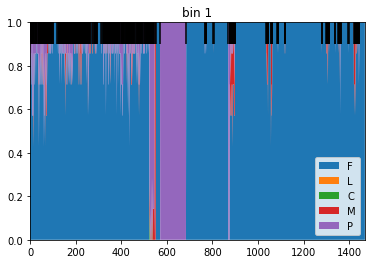

In [92]:
plot_time(bin_1_props, change_bin_1, "bin 1")

Currently there appears to be many false positive notifications. The model also seems to mislabel the sub-samples. 

### Bin 2

In [59]:
vid_path = "/content/drive/Shared drives/DSI Shared Folder/Module 2/Twist Data/bin_2.mp4"
bin_2_props, change_bin_2, bin2_time = video_prediction2(vid_path)

Starting video loop for 1440 frames
change found in frame: 2 ; class: chip
change found in frame: 2 ; class: pellets
change found in frame: 3 ; class: chip
change found in frame: 3 ; class: pellets
change found in frame: 4 ; class: chip
change found in frame: 4 ; class: pellets
change found in frame: 5 ; class: chip
change found in frame: 5 ; class: pellets
change found in frame: 7 ; class: chip
change found in frame: 7 ; class: pellets
change found in frame: 8 ; class: chip
change found in frame: 8 ; class: pellets
change found in frame: 9 ; class: chip
change found in frame: 9 ; class: mixed
change found in frame: 9 ; class: pellets
change found in frame: 10 ; class: mixed
change found in frame: 14 ; class: mixed
change found in frame: 15 ; class: mixed
change found in frame: 22 ; class: chip
change found in frame: 22 ; class: mixed
change found in frame: 23 ; class: chip
change found in frame: 24 ; class: chip
change found in frame: 24 ; class: mixed
change found in frame: 25 ; clas

In [70]:
bin2_time

0.21397134673749998

In [31]:
len(change_bin_2)

773

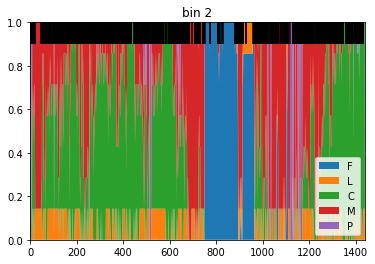

In [32]:
plot_time(bin_2_props, change_bin_2, "bin 2")

### Bin 3

In [93]:
vid_path = "/content/drive/Shared drives/DSI Shared Folder/Module 2/Twist Data/bin_3.mp4"
bin_3_props, change_bin_3, bin3_time = video_prediction3(vid_path)

Starting video loop for 1477 frames
change found in frame: 427 ; class: mixed
change found in frame: 428 ; class: mixed
change found in frame: 469 ; class: mixed
change found in frame: 470 ; class: mixed
change found in frame: 471 ; class: mixed
change found in frame: 474 ; class: chip
change found in frame: 474 ; class: mixed
change found in frame: 484 ; class: chip
change found in frame: 487 ; class: chip
change found in frame: 488 ; class: chip
change found in frame: 488 ; class: mixed
change found in frame: 490 ; class: chip
change found in frame: 491 ; class: mixed
change found in frame: 492 ; class: chip
change found in frame: 493 ; class: mixed
change found in frame: 494 ; class: chip
change found in frame: 494 ; class: mixed
change found in frame: 495 ; class: mixed
change found in frame: 498 ; class: chip
change found in frame: 498 ; class: mixed
change found in frame: 499 ; class: chip
change found in frame: 499 ; class: mixed
change found in frame: 501 ; class: chip
change f

In [94]:
bin3_time

0.1963672875152334

In [95]:
len(change_bin_3)

247

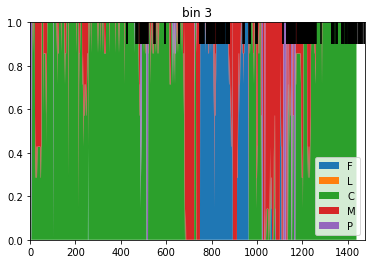

In [96]:
plot_time(bin_2_props, change_bin_3, "bin 3")

### Bin 4

In [97]:
vid_path = "/content/drive/Shared drives/DSI Shared Folder/Module 2/Twist Data/bin_4.mp4"
bin_4_props, change_bin_4, bin4_time = video_prediction4(vid_path)

Starting video loop for 1473 frames
change found in frame: 233 ; class: mixed
change found in frame: 234 ; class: mixed
change found in frame: 234 ; class: pellets
change found in frame: 235 ; class: pellets
change found in frame: 237 ; class: pellets
change found in frame: 238 ; class: mixed
change found in frame: 238 ; class: pellets
change found in frame: 239 ; class: mixed
change found in frame: 239 ; class: pellets
change found in frame: 240 ; class: mixed
change found in frame: 241 ; class: mixed
change found in frame: 242 ; class: mixed
change found in frame: 243 ; class: mixed
change found in frame: 245 ; class: mixed
change found in frame: 245 ; class: pellets
change found in frame: 246 ; class: pellets
change found in frame: 253 ; class: fines
change found in frame: 253 ; class: mixed
change found in frame: 254 ; class: fines
change found in frame: 255 ; class: mixed
change found in frame: 259 ; class: fines
change found in frame: 260 ; class: fines
change found in frame: 260

In [98]:
bin4_time

0.17412241527562816

In [99]:
len(change_bin_4)

96

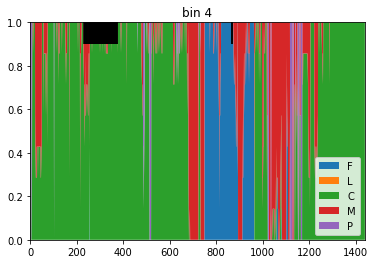

In [100]:
plot_time(bin_2_props, change_bin_4, "bin 4")

### Bin 5

In [54]:
vid_path = "/content/drive/Shared drives/DSI Shared Folder/Module 2/Twist Data/bin_5.mp4"
bin_5_props, change_bin_5, bin5_time = video_prediction5(vid_path)

Starting video loop for 1465 frames
change found in frame: 554 ; class: pellets
change found in frame: 556 ; class: pellets
change found in frame: 608 ; class: pellets
change found in frame: 610 ; class: pellets
change found in frame: 632 ; class: chip
change found in frame: 632 ; class: mixed
change found in frame: 635 ; class: mixed
change found in frame: 636 ; class: mixed
change found in frame: 639 ; class: chip
change found in frame: 639 ; class: mixed
change found in frame: 639 ; class: pellets
change found in frame: 646 ; class: chip
change found in frame: 646 ; class: pellets
change found in frame: 647 ; class: chip
change found in frame: 647 ; class: mixed
change found in frame: 648 ; class: chip
change found in frame: 648 ; class: mixed
change found in frame: 649 ; class: chip
change found in frame: 650 ; class: chip
change found in frame: 652 ; class: chip
change found in frame: 652 ; class: mixed
change found in frame: 653 ; class: chip
change found in frame: 654 ; class: m

In [55]:
bin5_time

0.1841186946470988

In [56]:
len(change_bin_5)

161

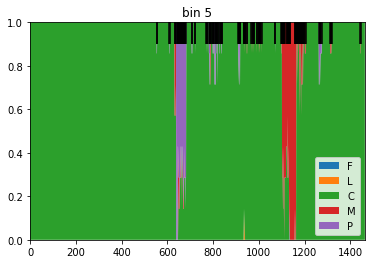

In [57]:
plot_time(bin_5_props, change_bin_5, "bin 5")

### Bin 6

In [69]:
vid_path = "/content/drive/Shared drives/DSI Shared Folder/Module 2/Twist Data/bin_6.mp4"
bin_6_props, change_bin_6, bin6_time = video_prediction6(vid_path)

Starting video loop for 1440 frames
change found in frame: 4 ; class: lump
change found in frame: 5 ; class: lump
change found in frame: 7 ; class: chip
change found in frame: 9 ; class: chip
change found in frame: 10 ; class: chip
change found in frame: 11 ; class: lump
change found in frame: 11 ; class: chip
change found in frame: 12 ; class: lump
change found in frame: 12 ; class: chip
change found in frame: 14 ; class: lump
change found in frame: 14 ; class: chip
change found in frame: 15 ; class: lump
change found in frame: 15 ; class: chip
change found in frame: 16 ; class: lump
change found in frame: 16 ; class: chip
change found in frame: 18 ; class: lump
change found in frame: 18 ; class: chip
change found in frame: 19 ; class: chip
change found in frame: 20 ; class: chip
change found in frame: 28 ; class: lump
change found in frame: 28 ; class: chip
change found in frame: 31 ; class: lump
change found in frame: 31 ; class: chip
change found in frame: 32 ; class: lump
change f

In [71]:
bin6_time

0.24748961264374997

In [72]:
len(change_bin_6)

539

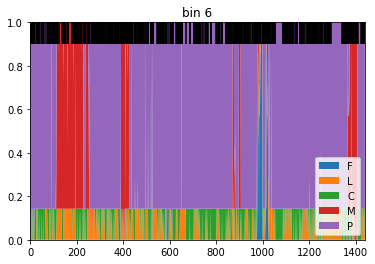

In [73]:
plot_time(bin_6_props, change_bin_6, "bin 6")

In [74]:
bin_6_props.iloc[10,:]

fines      0.000000
lump       0.000000
chip       0.142857
mixed      0.000000
pellets    0.857143
Name: 10, dtype: float64

In [75]:
bin_6_props.iloc[11,:]

fines      0.000000
lump       0.142857
chip       0.000000
mixed      0.000000
pellets    0.857143
Name: 11, dtype: float64

In [76]:
bin_6_props.iloc[12,:]

fines      0.000000
lump       0.000000
chip       0.142857
mixed      0.000000
pellets    0.857143
Name: 12, dtype: float64

### Bin 7

In [81]:
vid_path = "/content/drive/Shared drives/DSI Shared Folder/Module 2/Twist Data/bin_7.mp4"
bin_7_props, change_bin_7, bin7_time = video_prediction7(vid_path)

Starting video loop for 1489 frames
change found in frame: 1 ; class: pellets
change found in frame: 3 ; class: pellets
change found in frame: 4 ; class: pellets
change found in frame: 5 ; class: pellets
change found in frame: 6 ; class: fines
change found in frame: 6 ; class: pellets
change found in frame: 12 ; class: pellets
change found in frame: 13 ; class: pellets
change found in frame: 14 ; class: pellets
change found in frame: 15 ; class: pellets
change found in frame: 18 ; class: pellets
change found in frame: 19 ; class: fines
change found in frame: 19 ; class: pellets
change found in frame: 20 ; class: fines
change found in frame: 20 ; class: mixed
change found in frame: 20 ; class: pellets
change found in frame: 21 ; class: fines
change found in frame: 21 ; class: mixed
change found in frame: 21 ; class: pellets
change found in frame: 22 ; class: pellets
change found in frame: 24 ; class: pellets
change found in frame: 25 ; class: fines
change found in frame: 25 ; class: mix

In [82]:
bin7_time

0.3068418154647414

In [83]:
len(change_bin_7)

990

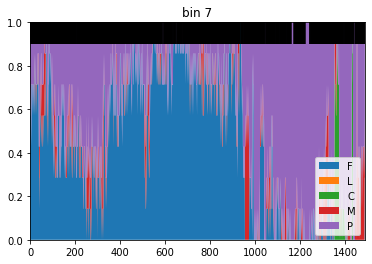

In [84]:
plot_time(bin_7_props, change_bin_7, "bin 7")